x_opt_cvx:  [ 1.06508114 -1.03551343 -2.59755737]
f_opt_cvx:  0.23604408109153946


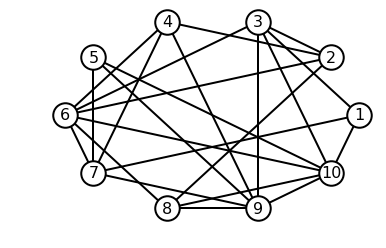

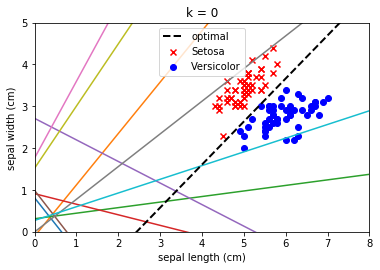

 16% (9997 of 60000) |###                | Elapsed Time: 0:00:48 ETA:   0:03:59

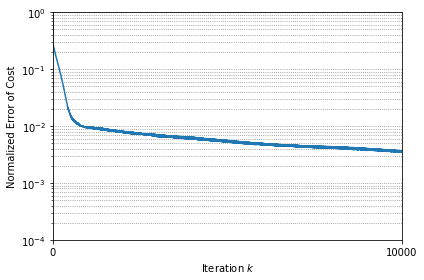

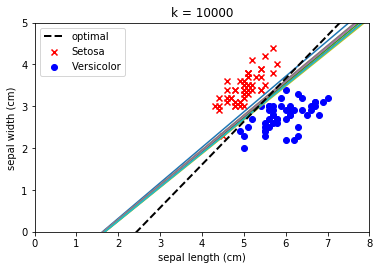

 33% (19982 of 60000) |#####             | Elapsed Time: 0:01:36 ETA:   0:03:12

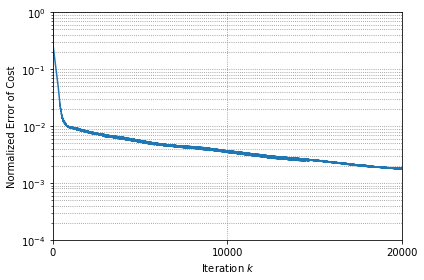

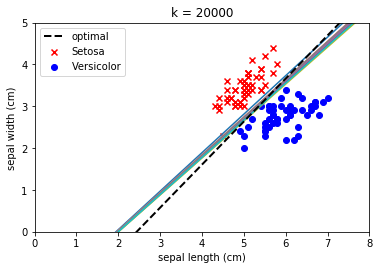

 49% (29995 of 60000) |########          | Elapsed Time: 0:02:25 ETA:   0:02:27

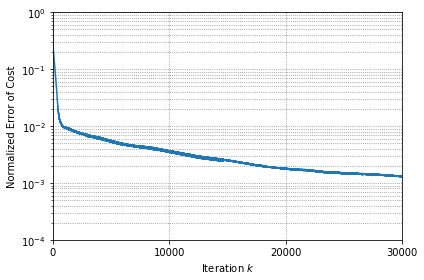

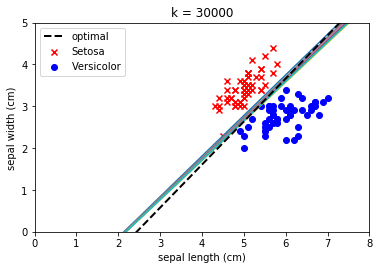

 66% (39980 of 60000) |###########       | Elapsed Time: 0:03:14 ETA:   0:01:36

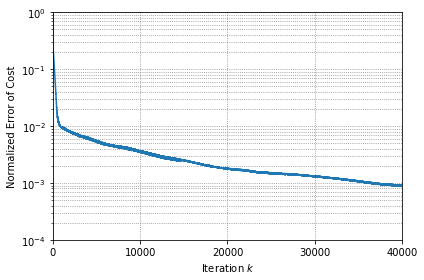

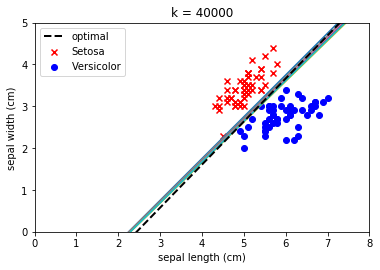

 83% (49983 of 60000) |##############    | Elapsed Time: 0:04:03 ETA:   0:00:48

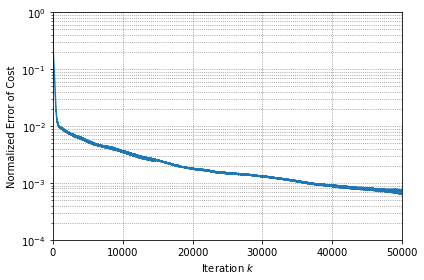

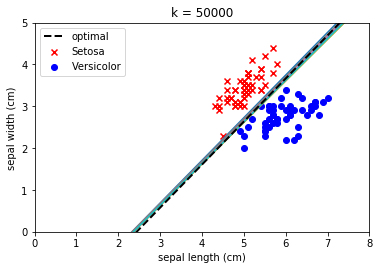

 99% (59991 of 60000) |################# | Elapsed Time: 0:04:52 ETA:   0:00:00

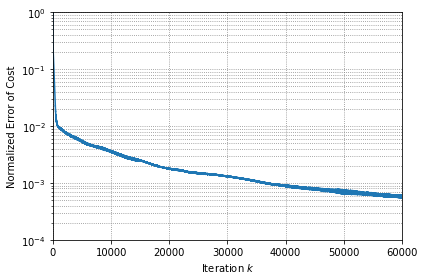

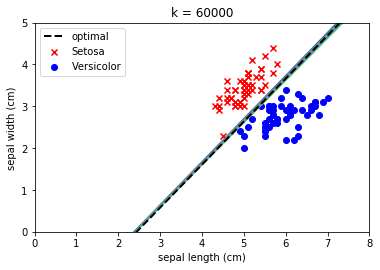

In [2]:
%matplotlib inline
#!/usr/bin/python
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA
import networkx as nx
import copy
import cvxpy as cvx

from sklearn import datasets
from sklearn.utils import shuffle
from progressbar import ProgressBar

# =========================================================================== #
class Agent_subgrad(object):
    def __init__(self, N, n, u, y, weight, name, s, C, nd, R):
        self.N = N
        self.n = n
        self.u_i = u
        self.y_i = y
        self.name = name
        self.weight = weight
        self.s = s
        self.C = C
        self.nd = nd
        self.R = R

        self.initial_state()

    # Initialization
    def initial_state(self):
        self.x_i = 4 * np.random.rand(self.n) - 2
        self.x = np.zeros([self.N, self.n])

    # The sign function
    def bsgn(self, x):
        sy = 0
        if x > 0:
            sy = 1
        return sy

    # Compute the gradient
    def grad(self):
        size = len(self.y_i)
        gtmp = np.zeros(self.n)

        for p in range(size):
            gtmp = gtmp + self.bsgn(1 - self.y_i[p] * np.dot(self.x_i, self.u_i[p])) * (-self.y_i[p] * self.u_i[p])

        tilde_x = self.x_i
        tilde_x[2] = 0

        return self.C * gtmp / self.nd + tilde_x / self.N

    # Compute the step-size
    def step_size(self, k, s):
        return s[2] / (k + s[0]) ** s[1]

    # Send the state to the neighbor agents
    def send(self, j):
        return self.x_i, self.name

    # Receive the states from the neighbor agents
    def receive(self, x_j, name):
        self.x[name] = x_j

    # Update the state by the distributed subgradient algorithm
    def update(self, k):
        self.x[self.name] = self.x_i
        self.x_i = np.dot(self.weight, self.x) - self.step_size(k, self.s) * self.grad()
        if np.linalg.norm(self.x_i) > self.R:
            self.x_i = self.R * self.x_i / LA.norm(self.x_i) #射影している！！
# =========================================================================== #
# Parameters

# Number of agents
N = 10

# Number of data
nd = 100

# Number of dimensions of the decision variable
m = 3

# Data size of each agent
M = int(nd / N)

# Coefficient of the step-size: s(k) = sc / (k + sa) ** sb
s = [4000, 0.51, 1.4]

# Coefficient of the edge weight: w_ij = wc / max_degree
wc = 0.8

# Regularization parameter for SVM
C = 5.0

# Constraint Set
R = 10

# Randomization seed
np.random.seed(1)

# Number of iterations
iteration = 60000

# Interval for figure plot
fig_interval = 10000

# Plot region
xmin = 0
xmax = 8
ymin = 0
ymax = 5

# =========================================================================== #
# Iris Dataset
iris = datasets.load_iris()

# Consider the first two attributes of Setosa and Versicolor
X0 = iris.data[:nd, :(m - 1)]

# Labels of data
y0 = iris.target[:nd]

# Change the labels of Setosa from 0 to -1
y0 = [-1 if i == 0 else i for i in y0]

# =========================================================================== #
# Data for agents

# Agents randomly choose the data
X1, y1 = shuffle(X0, y0)
X2 = np.hstack((X1, np.ones([nd, 1])))

agent_u = [X2[M * i:M * (i + 1)] for i in range(N)]
agent_y = [y1[M * i:M * (i + 1)] for i in range(N)]

# =========================================================================== #
# Centralized SVM (CVXPY)

# Decision Variable
xc = cvx.Variable(m)

f_opt = 0
for p in range(nd):
    f_opt = f_opt + cvx.pos(1 - y1[p] * xc.T * X2[p])
f_opt = (C * f_opt / nd + cvx.sum_squares(xc[0:2]) / 2) / N

# Optimization Function
objective = cvx.Minimize(f_opt)

# Constraints
constraints = [cvx.norm(xc, 2) <= R]

# Problem Formulation
prob = cvx.Problem(objective, constraints)

# Solve the optimization problem
prob.solve()

# Optimal Solution
x_opt = np.zeros(m)
x_opt_tmp = xc.value
x_opt[0] = x_opt_tmp[0]
x_opt[1] = x_opt_tmp[1]
x_opt[2] = x_opt_tmp[2]

# Optimal Cost
f_opt = prob.value

print('x_opt_cvx: ', x_opt)
print('f_opt_cvx: ', f_opt)

# =========================================================================== #
# Communication Graph

# Adjacency Matrix A
A = np.array(
    [[0, 0, 1, 0, 0, 0, 1, 0, 0, 1],
     [0, 0, 1, 1, 0, 1, 0, 1, 0, 0],
     [1, 1, 0, 0, 0, 1, 0, 0, 1, 1],
     [0, 1, 0, 0, 0, 1, 1, 0, 1, 0],
     [0, 0, 0, 0, 0, 0, 1, 0, 1, 1],
     [0, 1, 1, 1, 0, 0, 1, 1, 0, 1],
     [1, 0, 0, 1, 1, 1, 0, 0, 1, 0],
     [0, 1, 0, 0, 0, 1, 0, 0, 1, 1],
     [0, 0, 1, 1, 1, 0, 1, 1, 0, 1],
     [1, 0, 1, 0, 1, 1, 0, 1, 1, 0]])

G = nx.from_numpy_matrix(A)

# Plot a communication graph
pos = nx.circular_layout(G)
labels = {}
for i in range(N):
    labels[i] = r"{0}".format(i + 1)
nx.draw_networkx_nodes(G, pos, node_size=600, node_color='w', edgecolors='k', linewidths='2')
nx.draw_networkx_edges(G, pos, width=2)
nx.draw_networkx_labels(G, pos, labels, font_size=16)
plt.axis('off')
plt.show()

# Weighted Stochastic Matrix P
a = np.zeros(N)

for i in range(N):
    a[i] = copy.copy(wc / nx.degree(G)[i])

P = np.zeros((N, N))
for i in range(N):
    for j in range(i, N):
        if i != j and A[i][j] == 1:
            a_ij = min(a[i], a[j])
            P[i][j] = copy.copy(a_ij)
            P[j][i] = copy.copy(a_ij)

for i in range(N):
    sum = 0.0
    for j in range(N):
        sum += P[i][j]
    P[i][i] = 1.0 - sum

# =========================================================================== #
# Initialization
Agents = []
x_update = np.zeros(m)
x0 = [np.linspace(xmin, xmax) for i in range(N)]
y1 = [[] for i in range(N)]
prog = ProgressBar(max_value=iteration)

for i in range(N):
    Agents.append(Agent_subgrad(N, m, agent_u[i], agent_y[i], P[i], i, s, C, nd, R))

# ---------------------------------------------------- #
# Plot the initial estimation

plt.figure()
ax = plt.axes()

# Plot the initial estimations of agents
for i in range(N):
    y1[i] = (Agents[i].x_i[0] * x0[i] + Agents[i].x_i[2]) / (-Agents[i].x_i[1])
    plt.plot(x0[i], y1[i])

# Plot the (optimal) estimation by CVXPY
x00 = np.linspace(xmin, xmax).reshape(-1, 1)
x01 = (x_opt[0] * x00 + x_opt[2]) / (-x_opt[1])
plt.plot(x00, x01, "k--", lw=2, label="optimal")

# Plot the data
plt.scatter(X0[:int(nd / 2), 0], X0[:int(nd / 2), 1], color='r', marker='x', label='Setosa')
plt.scatter(X0[int(nd / 2):nd, 0], X0[int(nd / 2):nd, 1], color='b', marker='o', label='Versicolor')

ax.set_aspect('equal')
plt.title('k = 0')
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.legend()
plt.show()

# =========================================================================== #
# Algorithm
f_er_base = 0
fe_list = []

for k in range(iteration):
    prog.update(k)

    # --------------------------------------------------------------------------#
    # Evaluate the normalized costs of agents
    f = 0
    for i in range(N):
        x_update = Agents[i].x_i
        ftmp = 0
        for j in range(N):
            for p in range(M):
                ftmp = ftmp + max(1 - agent_y[j][p] * np.dot(x_update, agent_u[j][p]), 0)
        f = f + C * ftmp / nd + LA.norm(x_update[0:2]) ** 2 / 2
    f = f / N

    if k == 0:
        f_er_base = f - N * f_opt

    fe_list.append((f - N * f_opt) / f_er_base)
    # --------------------------------------------------------------------------#

    for i in range(N):
        for j in range(N):
            if j != i:
                # Send the state to the neighbor agents
                state, name = Agents[i].send(j)

                # Receive the states from the neighbor agents
                Agents[j].receive(state, name)

    # Update the state
    for i in range(N):
        Agents[i].update(k)

    # --------------------------------------------------------------------------#
    # Plot graphs

    if (k + 1) % fig_interval == 0:
        plt.figure()
        plt.plot(fe_list)
        plt.xlabel("Iteration $k$")
        plt.ylabel('Normalized Error of Cost')
        plt.yscale("log")
        plt.xlim([0, k + 2])
        plt.ylim([10**(-4), 1])
        plt.xticks(np.arange(0, k + 2, fig_interval))
        plt.grid(which='major', color='gray', linestyle=':')
        plt.grid(which='minor', color='gray', linestyle=':')
        plt.tight_layout()
        plt.show()

        plt.figure()
        ax = plt.axes()
        for i in range(N):
            y1[i] = (Agents[i].x_i[0] * x0[i] + Agents[i].x_i[2]) / (-Agents[i].x_i[1])
            plt.plot(x0[i], y1[i])
        x01 = (x_opt[0] * x00 + x_opt[2]) / (-x_opt[1])
        plt.plot(x00, x01, "k--", lw=2, label="optimal")
        plt.scatter(X0[:int(nd / 2), 0], X0[:int(nd / 2), 1], color='r', marker='x', label='Setosa')
        plt.scatter(X0[int(nd / 2):nd, 0], X0[int(nd / 2):nd, 1], color='b', marker='o', label='Versicolor')
        ax.set_aspect('equal')
        plt.title('k = {}'.format(k + 1))
        plt.xlim([xmin, xmax])
        plt.ylim([ymin, ymax])
        plt.xlabel(iris.feature_names[0])
        plt.ylabel(iris.feature_names[1])
        plt.legend()
        plt.show()